In [1]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and filter data
MIN_REVENUE_KSEK = 1_000
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"]))]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 105 | Samples: 889,889
Target distribution:
target_next_year
0    875385
1     14504
Name: count, dtype: Int64
Imbalance: 60.4:1


In [3]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train: {len(X_train):,} | Val: {len(X_val):,}")

Train: 711,911 | Val: 177,978


In [4]:
model = lgb.LGBMClassifier(
        n_estimators=10_000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary',
        is_unbalance=False,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        metric='logloss',
        # reg_alpha=0.1,
        # reg_lambda=0.1
)

start_time = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(50, verbose=True), lgb.log_evaluation(50)]
)

training_time = time.time() - start_time
print(f"\nLightGBM training completed in {training_time:.1f}s ({training_time/60:.1f} min)")

print(f"\nBest iteration: {model.best_iteration_}")

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0353437	valid_1's binary_logloss: 0.037134
[100]	training's binary_logloss: 0.0314492	valid_1's binary_logloss: 0.0351609
[150]	training's binary_logloss: 0.0287295	valid_1's binary_logloss: 0.0345158
[200]	training's binary_logloss: 0.0266981	valid_1's binary_logloss: 0.0343574
[250]	training's binary_logloss: 0.0251235	valid_1's binary_logloss: 0.034241
[300]	training's binary_logloss: 0.0238872	valid_1's binary_logloss: 0.034149
[350]	training's binary_logloss: 0.0227107	valid_1's binary_logloss: 0.034127
[400]	training's binary_logloss: 0.0216967	valid_1's binary_logloss: 0.0340708
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0220211	valid_1's binary_logloss: 0.0340664

LightGBM training completed in 14.4s (0.2 min)

Best iteration: 381


In [5]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=100, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='quantile'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

AUC: 0.9625
PR-AUC: 0.6847

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    175077
         1.0       0.93      0.52      0.67      2901

    accuracy                           0.99    177978
   macro avg       0.96      0.76      0.83    177978
weighted avg       0.99      0.99      0.99    177978


Confusion Matrix:
[[174969    108]
 [  1387   1514]]


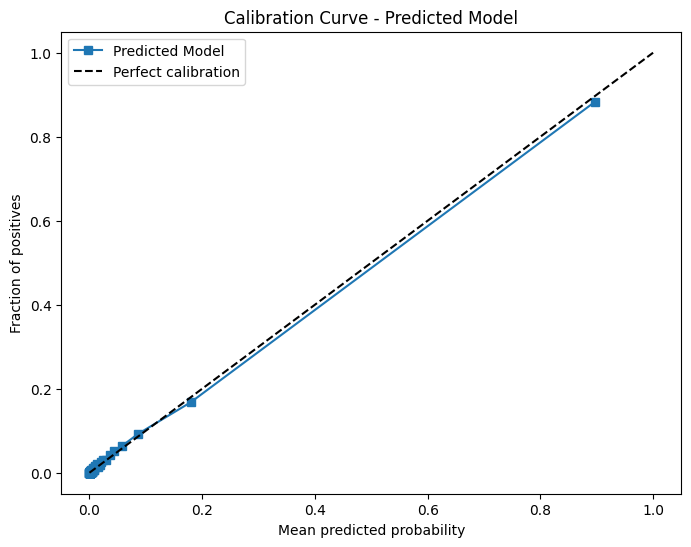

ECE: 0.0015


In [6]:
# Evaluate
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="Predicted Model")

Top Features (by Gain):
                        feature    importance
  years_since_last_credit_event 240471.422413
ratio_ebit_interest_cov_yoy_pct  90792.720330
                        ny_omsf  53975.874695
                    ny_avkegkap  53584.234021
                      br10_eksu  45255.995332
              event_count_total  31202.548369
                   ny_nettomarg  24168.003967
              dso_days_yoy_diff  22973.211569
          rr07_rorresul_yoy_pct  16582.247151
   ratio_cash_liquidity_yoy_pct  14190.954736
          ratio_dividend_payout  13506.402231
                       dpo_days  12486.216008
             rr01_ntoms_yoy_pct  11780.880230
            event_count_last_5y  10857.995933
                ny_foradlvpanst  10521.124269
                       ny_anstf   8867.905090
                     rr15_resar   8575.483842
                   br07b_kabasu   7373.368079
                    ny_skuldgrd   7288.544301
           ratio_cash_liquidity   6652.299241
          

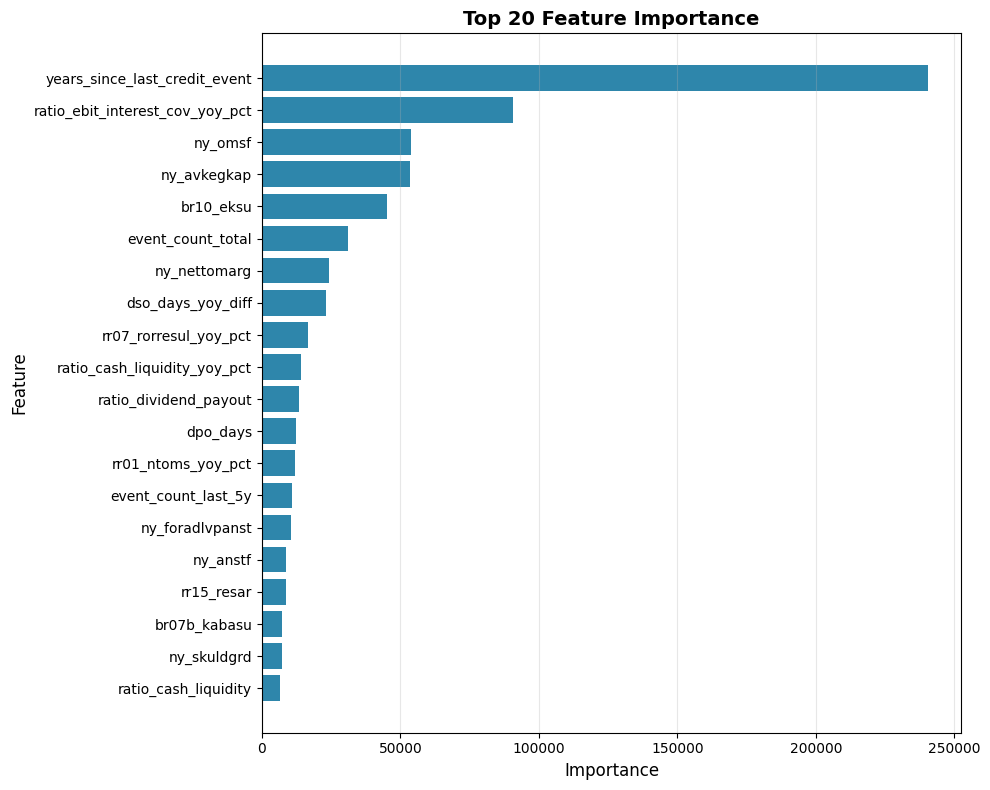


Feature Group Importance Analysis
               group  total_importance  mean_importance  feature_count
              CRISIS     282531.966714     94177.322238              3
               OTHER     281134.280041      9371.142668             30
               TREND     266043.797028      6334.376120             42
               RATIO      53941.429266      3596.095284             15
LIQUIDITY_EFFICIENCY      16633.440207      5544.480069              3
               MACRO      15033.496022      1252.791335             12


In [7]:
# Feature importance analysis
from credit_risk_xai.modeling import get_feature_importance, plot_feature_importance, analyze_feature_groups
from credit_risk_xai.config import (
    RATIO_FEATURE_NAMES, 
    LIQUIDITY_EFFICIENCY_FEATURES, 
    TREND_FEATURE_NAMES, 
    CRISIS_FEATURE_NAMES, 
    MACRO_FEATURE_NAMES
)

# 1. Get LightGBM feature importance (using gain)
importance_df = get_feature_importance(model, X_train, importance_type='gain', top_n=None)
print("Top Features (by Gain):")
print(importance_df.to_string(index=False))

# 2. Visualize feature importance
plot_feature_importance(importance_df, top_n=20, show=True)

# 3. Analyze by feature groups
feature_groups = {
    "RATIO": RATIO_FEATURE_NAMES,
    "LIQUIDITY_EFFICIENCY": LIQUIDITY_EFFICIENCY_FEATURES,
    "TREND": TREND_FEATURE_NAMES,
    "CRISIS": CRISIS_FEATURE_NAMES,
    "MACRO": MACRO_FEATURE_NAMES,
}

group_stats = analyze_feature_groups(model, X_train, feature_groups, importance_type='gain')
print("\n" + "="*80)
print("Feature Group Importance Analysis")
print("="*80)
print(group_stats.to_string(index=False))

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top 117 Features (by SHAP):
                        feature  mean_abs_shap
          ratio_dividend_payout       0.431307
           ratio_cash_liquidity       0.174707
                    ny_avkegkap       0.174493
                      br10_eksu       0.163957
                   ny_nettomarg       0.148502
                    company_age       0.141658
             rr01_ntoms_yoy_abs       0.137503
                       dpo_days       0.136779
        ratio_ebit_interest_cov       0.131257
                          ny_rs       0.128323
            revenue_drawdown_5y       0.113573
                ny_foradlvpanst       0.112219
                     ny_kapomsh       0.111493
                    knc_kncfall       0.097407
            bransch_sni071_konv       0.095463
                   br07b_kabasu       0.092139
      ratio_secured_debt_assets       0.088925
  years_since_last_credit_event       0.080380
             ny_skuldgrd_vol_5y       0.078145
   ratio_cash_liquidity_yoy_pct 

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


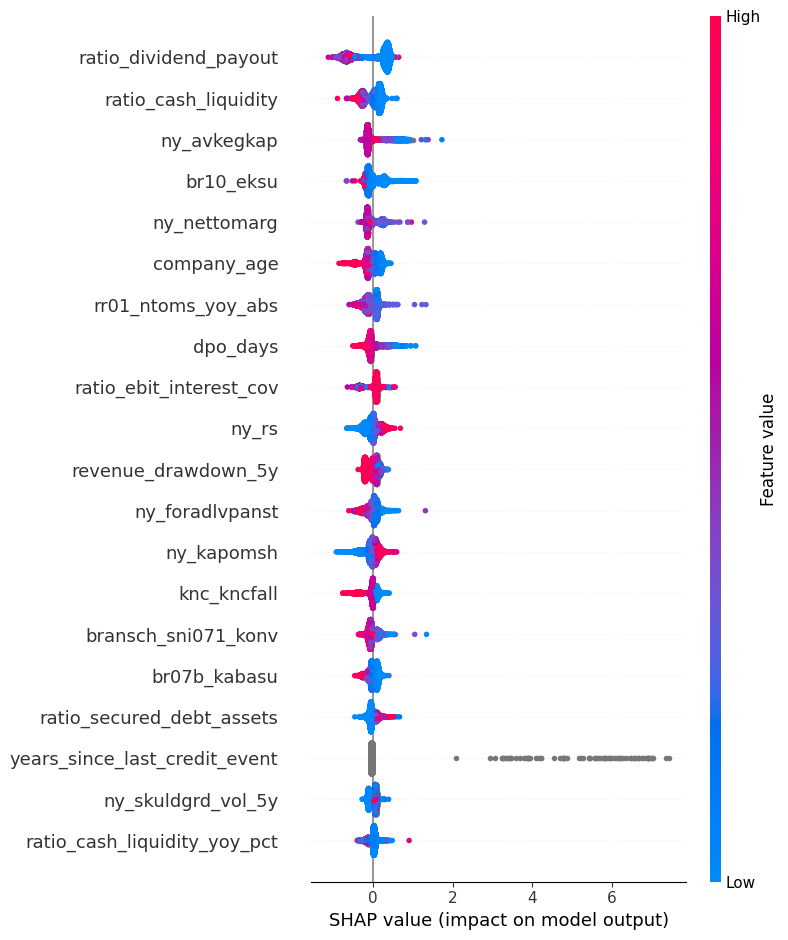

In [8]:
# SHAP analysis
from credit_risk_xai.modeling import get_shap_feature_importance, compute_shap_values
import shap

# 1. Compute SHAP-based feature importance
sample_size = min(10_000, len(X_val))
shap_importance = get_shap_feature_importance(model, X_val, max_samples=sample_size, top_n=None)

print("Top 117 Features (by SHAP):")
print(shap_importance.to_string(index=False))

# 2. Compare native importance vs SHAP
comparison = importance_df.merge(shap_importance, on='feature', how='inner')
comparison['importance_rank'] = comparison['importance'].rank(ascending=False)
comparison['shap_rank'] = comparison['mean_abs_shap'].rank(ascending=False)
comparison['rank_diff'] = abs(comparison['importance_rank'] - comparison['shap_rank'])
comparison = comparison.sort_values('rank_diff', ascending=False)

print("\n" + "="*80)
print("Features with Largest Rank Difference (Gain vs SHAP)")
print("="*80)
print(comparison[['feature', 'importance', 'importance_rank', 'mean_abs_shap', 'shap_rank', 'rank_diff']].head(15).to_string(index=False))

# 3. Generate SHAP summary plot
print(f"\nGenerating SHAP summary plot on {sample_size:,} samples...")
explainer, shap_values, X_sample = compute_shap_values(model, X_val, max_samples=sample_size)

# Handle binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_sample, max_display=20)

In [9]:
# Correlation analysis by financial statement source
from credit_risk_xai.modeling import (
    get_feature_correlations_by_source,
    find_high_correlations,
    plot_correlation_heatmap,
    summarize_within_group_correlations
)
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# 1. Summary of within-group correlations
print("=" * 90)
print("WITHIN-GROUP CORRELATION SUMMARY")
print("=" * 90)
group_summary = summarize_within_group_correlations(X_train, FEATURE_GROUPS_BY_SOURCE)
print(group_summary.to_string(index=False))

# 2. Compute correlations for each group
corr_by_source = get_feature_correlations_by_source(X_train, FEATURE_GROUPS_BY_SOURCE)

# 3. Find and display high correlations in each group
print("\n" + "=" * 90)
print("HIGH CORRELATIONS BY GROUP (|r| > 0.7)")
print("=" * 90)

for group_name in ["MACRO", "DERIVED_RATIOS", "WORKING_CAPITAL", "OPERATIONAL"]:
    if group_name not in corr_by_source:
        continue
    
    high_corrs = find_high_correlations(corr_by_source[group_name], threshold=0.7, top_n=50)
    
    if len(high_corrs) > 0:
        print(f"\n{group_name} - Top 50 Correlated Pairs:")
        print(high_corrs.to_string(index=False))
    else:
        print(f"\n{group_name} - No correlations above 0.7")

WITHIN-GROUP CORRELATION SUMMARY
           group  feature_count  mean_corr  median_corr  max_corr  min_corr  high_corr_pairs
  CRISIS_HISTORY              3   0.257203    -0.041736  0.901216 -0.087872                1
INCOME_STATEMENT              9   0.165416     0.009577  0.991029 -0.000013                6
   BALANCE_SHEET              9   0.140891     0.009853  0.904377 -0.056832                3
 WORKING_CAPITAL             10   0.032353    -0.000006  0.476138 -0.943930                1
  DERIVED_RATIOS             18   0.029542    -0.000003  0.913169 -0.943930               13
          TRENDS             42   0.022871     0.000119  0.957414 -0.982638               24
     OPERATIONAL              5   0.011367     0.000356  0.137555 -0.056125                0
           MACRO             12  -0.036828     0.000002  0.486881 -0.691560                0

HIGH CORRELATIONS BY GROUP (|r| > 0.7)

MACRO - No correlations above 0.7

DERIVED_RATIOS - Top 50 Correlated Pairs:
            

Generating correlation heatmap for MACRO features...


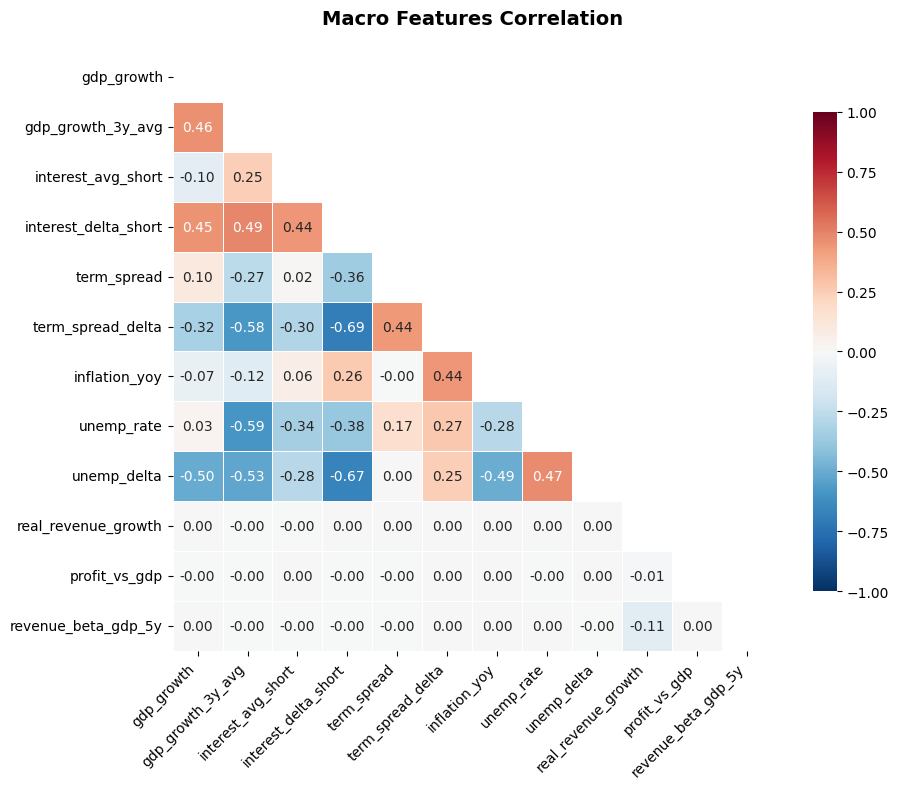


Generating correlation heatmap for WORKING_CAPITAL features...


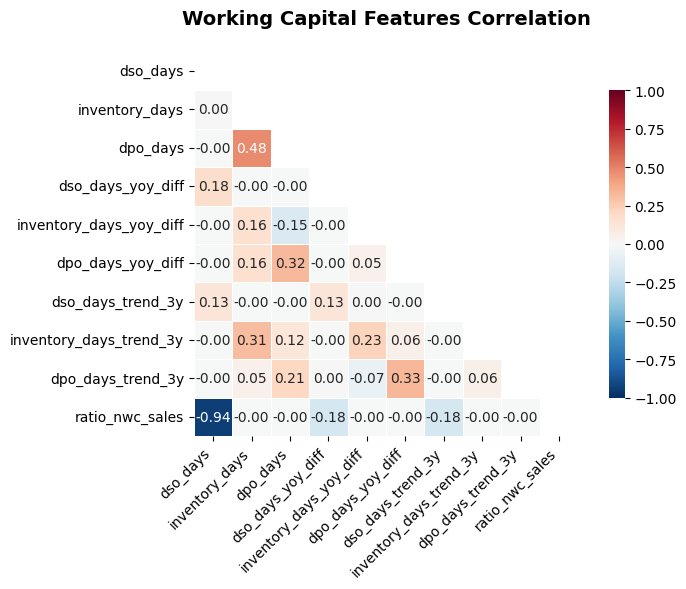


Generating correlation heatmap for DERIVED_RATIOS features...


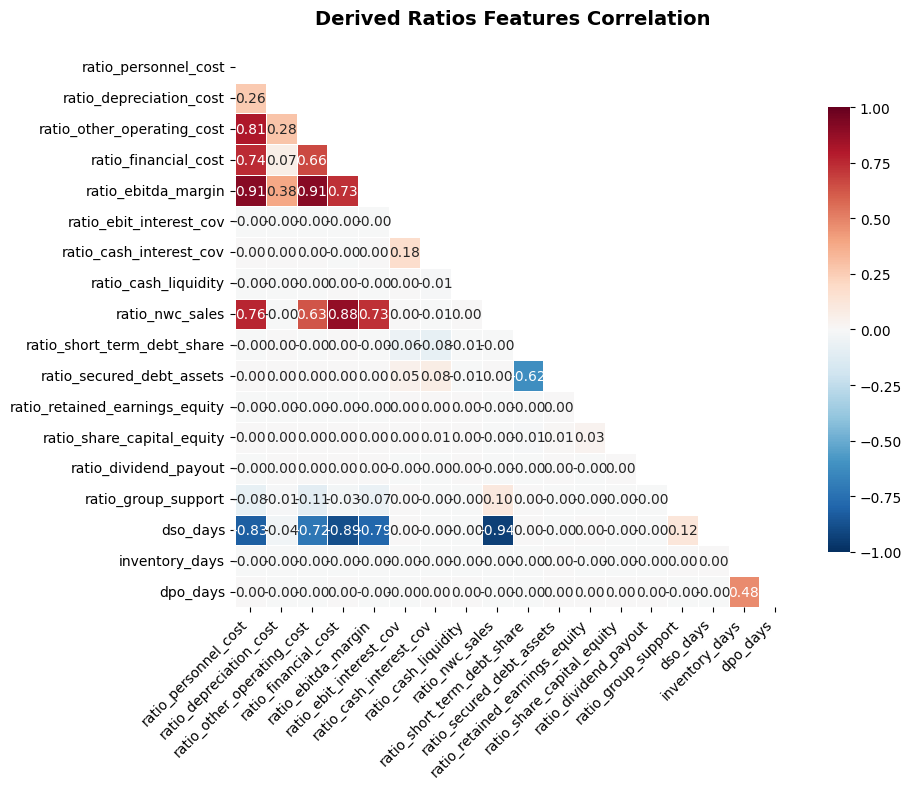


Generating correlation heatmap for OPERATIONAL features...


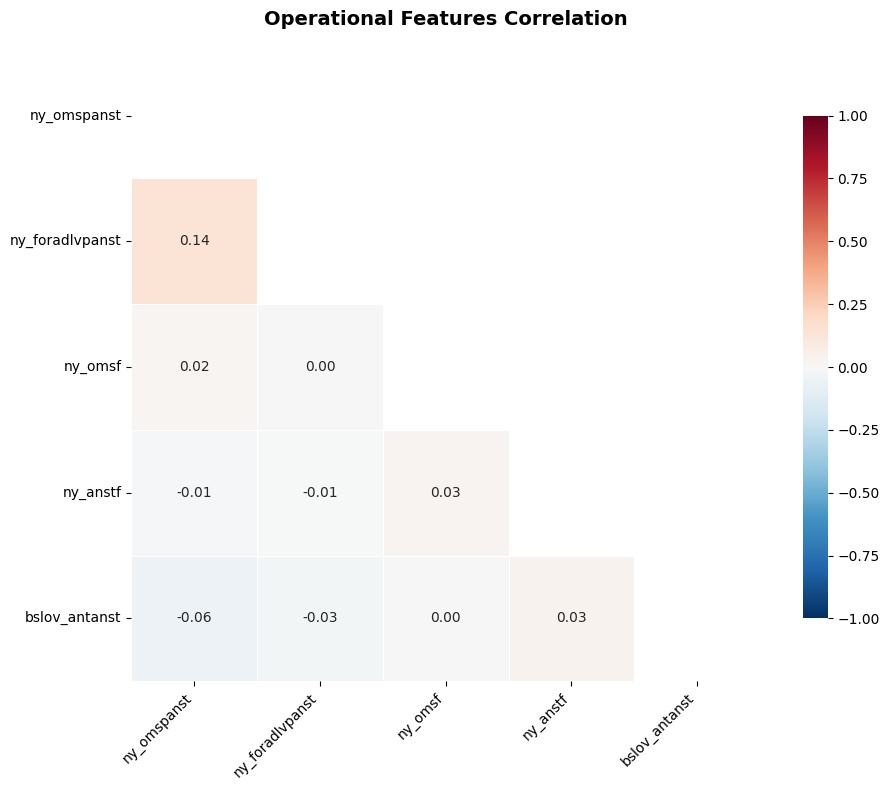

In [10]:
# Visualize correlations for selected groups

if "MACRO" in corr_by_source:
    print("Generating correlation heatmap for MACRO features...")
    plot_correlation_heatmap(
        corr_by_source["MACRO"],
        title="Macro Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )

if "WORKING_CAPITAL" in corr_by_source:
    print("\nGenerating correlation heatmap for WORKING_CAPITAL features...")
    plot_correlation_heatmap(
        corr_by_source["WORKING_CAPITAL"],
        title="Working Capital Features Correlation",
        figsize=(8, 6),
        annot=True,
        mask_diagonal=True,
        show=True
    )

if "DERIVED_RATIOS" in corr_by_source:
    print("\nGenerating correlation heatmap for DERIVED_RATIOS features...")
    plot_correlation_heatmap(
        corr_by_source["DERIVED_RATIOS"],
        title="Derived Ratios Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )
if "OPERATIONAL" in corr_by_source:
    print("\nGenerating correlation heatmap for OPERATIONAL features...")
    plot_correlation_heatmap(
        corr_by_source["OPERATIONAL"],
        title="Operational Features Correlation",
        figsize=(10, 8),
        annot=True,
        mask_diagonal=True,
        show=True
    )

In [11]:
# Feature-target correlation and comparison with importance
from credit_risk_xai.modeling import analyze_correlation_with_target, compare_correlation_vs_importance

# 1. Features most correlated with default risk
print("=" * 90)
print("TOP 30 FEATURES CORRELATED WITH TARGET (Default Risk)")
print("=" * 90)
target_corr = analyze_correlation_with_target(X_train, y_train, method='pearson', top_n=30)
print(target_corr.to_string(index=False))

# 2. Compare importance vs correlation - identify interesting patterns
print("\n" + "=" * 90)
print("IMPORTANCE vs CORRELATION COMPARISON")
print("=" * 90)
print("High rank_diff = feature has very different importance rank vs correlation rank")
print("=" * 90)

comparison = compare_correlation_vs_importance(X_train, y_train, importance_df, top_n=30)
print(comparison.to_string(index=False))

# 3. Interpret patterns
print("\n" + "=" * 90)
print("INTERPRETATION PATTERNS")
print("=" * 90)

# High importance but low correlation → nonlinear effects
nonlinear_features = comparison[
    (comparison['importance_rank'] <= 20) & 
    (comparison['corr_rank'] > 40)
].head(10)

if len(nonlinear_features) > 0:
    print("\n🔍 High Importance + Low Correlation (Nonlinear/Interaction Effects):")
    print(nonlinear_features[['feature', 'importance_rank', 'corr_rank', 'target_corr']].to_string(index=False))

# High correlation but low importance → redundant features
redundant_features = comparison[
    (comparison['corr_rank'] <= 20) & 
    (comparison['importance_rank'] > 40)
].head(10)

if len(redundant_features) > 0:
    print("\n⚠️  High Correlation + Low Importance (Potentially Redundant):")
    print(redundant_features[['feature', 'importance_rank', 'corr_rank', 'target_corr']].to_string(index=False))

TOP 30 FEATURES CORRELATED WITH TARGET (Default Risk)


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_

                      feature  correlation  abs_correlation
          event_count_last_5y     0.470078         0.470078
            event_count_total     0.395278         0.395278
years_since_last_credit_event    -0.104833         0.104833
                     ny_solid    -0.074290         0.074290
          revenue_drawdown_5y    -0.064472         0.064472
    ratio_secured_debt_assets     0.052808         0.052808
                  company_age    -0.032416         0.032416
                  knc_kncfall    -0.029532         0.029532
                   rr01_ntoms    -0.021888         0.021888
               equity_cagr_5y    -0.019288         0.019288
          bransch_sni071_konv    -0.019237         0.019237
                rr07_rorresul    -0.017191         0.017191
      ratio_cash_interest_cov     0.013936         0.013936
            ny_solid_yoy_diff    -0.012612         0.012612
                  ny_avktokap    -0.012531         0.012531
      ratio_ebit_interest_cov     0.0121

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.

                       feature   importance  target_corr  importance_rank  corr_rank  rank_diff
                    gdp_growth   681.899456    -0.010573            103.0       19.0       84.0
         ratio_dividend_payout 13506.402231     0.000070             11.0       92.0       81.0
           revenue_drawdown_5y  1514.002318    -0.064472             83.0        5.0       78.0
                    rr01_ntoms  1468.536420    -0.021888             87.0        9.0       78.0
             dso_days_yoy_diff 22973.211569     0.000189              8.0       86.0       78.0
                    unemp_rate  1017.353091    -0.009024             96.0       22.0       74.0
                       ny_omsf 53975.874695    -0.000416              3.0       76.0       73.0
             gdp_growth_3y_avg   525.827389    -0.006137            104.0       32.0       72.0
                      dpo_days 12486.216008     0.000258             12.0       79.0       67.0
             term_spread_delta   898.594

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2908: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
